# Importing the classifier pickle
NOTE: pickle must contain the trained __classifier__, not just the model.

In [16]:
import os
import math
import json
import pickle
import numpy as np
import statistics as stats

from sklearn import tree
from pandas import DataFrame
from matplotlib import pyplot as plt

# ------ Fill this in to specify which pickle should be opened ------
# --- NOTE: should include full path and filename but NO extension ---
file = "stored_models/trained_classifiers/dtc/dtc-head-16-cdiac_multilabel_gt_copy.csv-2022-03-31-05.26.30"
# --------------------------------------------------------------

byte_count = int(file.split("/")[-1].split("-")[2])

classifier_path = f"{file}.pkl"
info_metrics_path = f"{file}-info-{byte_count}Bytes.json"

info_metrics = json.load(open(info_metrics_path))

# os.chdir('../XtractPredictor/')
classifier = pickle.load(open(classifier_path, "rb"))
# os.chdir('../xtract-research-notebooks/')

for key in info_metrics.keys():
    print(key)
    print(f'\t{info_metrics[key]}')

precision = info_metrics['Model precision']
recall = info_metrics['Model recall']
print(f'F1-Score\n\t{2*precision*recall/(precision+recall)}')

Classifier
	dtc
Dataset Trained On
	head-16-cdiac_multilabel_gt_copy.csv
Train and test time
	12.295641660690308
Model accuracy
	0.9740782055895406
Model precision
	0.924656730938137
Model recall
	0.9141257375350739
Model size
	43766719
Parameters
	{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4000, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}
Run as multilabel?
	True
F1-Score
	0.9193610779174223


# Decision tree visualization
Acceptable classifiers:
- Decision tree classifier (dtc)
- Single-tree extra tree classifier (t_etc)

NOTE: If decision tree has too high of a maximum depth, this visualization will be illegible. I recommend setting max_depth to 3.

In [ ]:
fig = plt.figure(figsize=(25, 25))
_ = tree.plot_tree(classifier.model,
                   filled=True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
label_legend = ""
for label in classifier.unique_labels:
    label_legend += (label + "\n")
fig.text(0.13, 0.7, label_legend[:-1], fontsize=25, bbox=props)

# HeadByte heatmap visualization
*Acceptable classifiers: any*

In [ ]:
y_pred = classifier.model.predict(classifier.X_test)

# Building a dictionary of the predicted (multi)labels and their corresponding binary lists

unique_rows = np.unique(y_pred, axis=0)
unique_dict = {}
for unique_row in unique_rows:
    labels = []
    for pair in zip(unique_row, classifier.unique_labels):
        if pair[0]:
            labels.append(pair[1])
    if len(labels) == 0:
        labels.append("unknown")
    unique_dict[", ".join(labels)] = unique_row
    
# Building a dictionary of all the feature info for each predicted label

large_dict = {}
for key in unique_dict.keys():
    large_dict[key] = []

for i in range(len(classifier.X_test)):
    for key in unique_dict.keys():
        if np.all(y_pred[i]==unique_dict[key]):
            large_dict[key].append(classifier.X_test[i].tolist())
            break

sample_counts = "Predicted sample counts\n\n"
for key in large_dict.keys():
    sample_counts += key + " : " + str(len(large_dict[key])) + "\n"

print("The labels and their binarized lists:")
for key in unique_dict.keys():
    print(key)
    print(unique_dict[key])

## Average value heatmap

In [ ]:
# Averaging the features for each bit

avgs = []
for key in large_dict.keys():
    lst = large_dict[key]
    lst = [list(x) for x in zip(*lst)]
    lst = [stats.mean(x) for x in lst]
    avgs.append(lst)
    
# UNCOMMENT to fill in empty labels in case you run on a limited range of samples

# for i in range(len(avgs)):
#     if (len(avgs[i])==0):
#         avgs[i] = [0.0] * byte_count

# Creating the plot

fig, ax1 = plt.subplots()

# Label y axis side with the class name

y1_axis_labels = large_dict.keys()
ax1.set_yticks(np.arange(len(y1_axis_labels)), labels=y1_axis_labels)

# Plot the heatmap set good x-axis ticks

fig.set_size_inches((2*byte_count)/10, 10.5) # UNCOMMENT FOR LARGER BYTECOUNTS
plt.imshow(np.array(avgs))
plt.xticks(ticks=[i for i in range(byte_count)], labels=[i+1 for i in range(byte_count)])

# Adding title and sample count legend

ax1.set_title("Average scalar value of n-th head byte for each predicted multilabel")
plt.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(byte_count, -0.25, sample_counts[:-1], fontsize=10,
         verticalalignment='top', bbox=props)

## Standard deviation heatmap

In [ ]:
# Finding the standard deviation for each bit

stdevs = []
y_axis_labels = []
for key in large_dict.keys():
    lst = large_dict[key]
    lst = [list(x) for x in zip(*lst)]
    if (len(lst[0])>1):
        lst = [stats.stdev(x) for x in lst]
        stdevs.append(lst)
        y_axis_labels.append(key)
    
# UNCOMMENT to fill in empty labels in case you run on a limited range of samples

# for i in range(len(stdevs)):
#     if (len(stdevs[i])==0):
#         stdevs[i] = [0.0] * byte_count

# Creating the plot

fig, ax = plt.subplots()
im = ax.imshow(np.array(stdevs))

# Show all ticks and label them with the respective list entries

ax.set_yticks(np.arange(len(y_axis_labels)), labels=y_axis_labels)

# Plot the heatmap set good x-axis ticks

fig.set_size_inches(18.5, 10.5) # UNCOMMENT FOR LARGER BYTECOUNTS
plt.imshow(np.array(stdevs))
plt.xticks(ticks=[i for i in range(byte_count)], labels=[i+1 for i in range(byte_count)])

# Adding title and sample count legend

ax1.set_title("Standard deviation of scalar values of n-th head byte")
plt.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(byte_count, -0.25, sample_counts[:-1], fontsize=10,
         verticalalignment='top', bbox=props)

# Multilabel Confusion Matrices
*Acceptable classifiers: any*

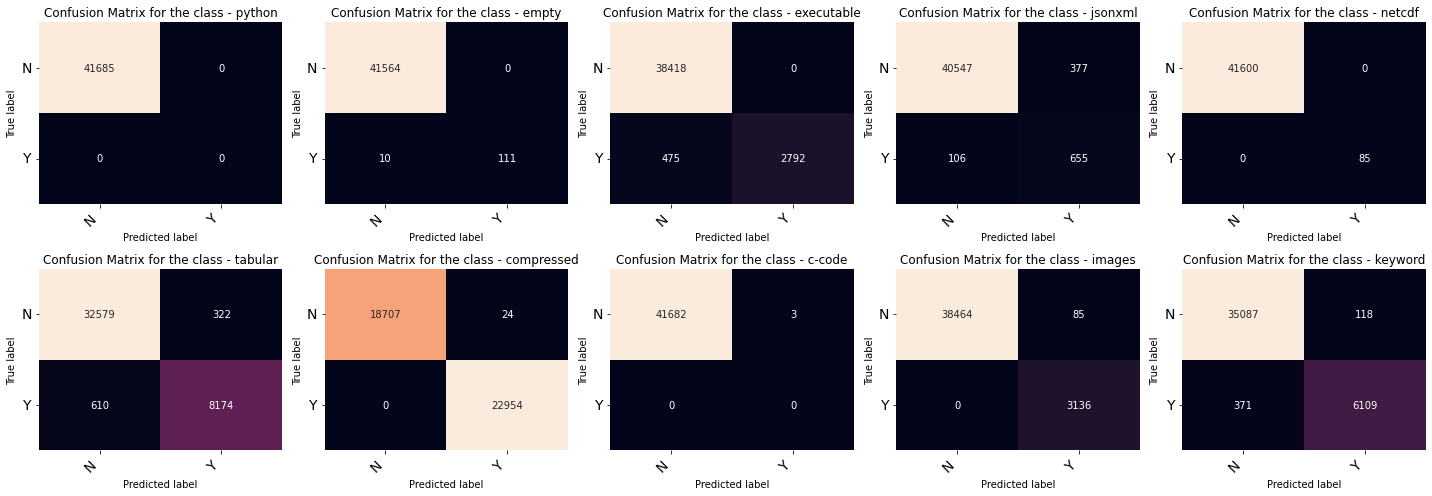

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

y_pred = classifier.model.predict(classifier.X_test)
    
# Some customizable values here, first two values should multiply to at least label count
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
    
multilabel_confusion_matrix = multilabel_confusion_matrix(y_pred, classifier.Y_test)
multilabel_labels = classifier.unique_labels

for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix, multilabel_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

# Precision-Recall Curve

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(classifier.Y_test[0])
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(classifier.Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(classifier.Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

NameError: name 'Y_test' is not defined

In [24]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = classifier.model.predict(classifier.X_test)
    
multilabel_confusion_matrix = multilabel_confusion_matrix(y_pred, classifier.Y_test)
multilabel_labels = classifier.unique_labels

# for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_confusion_matrix, multilabel_labels):
#     print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
tps = []
fps = []
fns = []
for cfs_matrix, label in zip(multilabel_confusion_matrix, multilabel_labels):
    print(label)
    print(cfs_matrix)
    tps.append(cfs_matrix[1][1])
    fps.append(cfs_matrix[0][1])
    fn = cfs_matrix[1][0]

micro_prec_avg = sum(tps) / (sum(tps)+sum(fps))
micro_recall_avg = sum

print(classifier.unique_labels)

python
[[41685     0]
 [    0     0]]
empty
[[41564     0]
 [   10   111]]
executable
[[38418     0]
 [  475  2792]]
jsonxml
[[40547   377]
 [  106   655]]
netcdf
[[41600     0]
 [    0    85]]
tabular
[[32579   322]
 [  610  8174]]
compressed
[[18707    24]
 [    0 22954]]
c-code
[[41682     3]
 [    0     0]]
images
[[38464    85]
 [    0  3136]]
keyword
[[35087   118]
 [  371  6109]]
[0, 111, 2792, 655, 85, 8174, 22954, 0, 3136, 6109]
44016
0.9793302925798197
['python', 'empty', 'executable', 'jsonxml', 'netcdf', 'tabular', 'compressed', 'c-code', 'images', 'keyword']
